<a href="https://colab.research.google.com/github/michuii-hu36/MLT_/blob/main/Week_3_MLT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Polynomial Regression

Features --> Polynomial transformation --> Linear regression --> Label

We will use Linear regression class that implements Linear regression model

In [1]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Math, Latex

In [2]:
a = np.zeros((15,))
a[::2] = 1
a[1::2] = 0
a

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

#Linear Regression class

In [3]:
class LinReg(object):
  """
  y = X@w
  X: A feature matrix
  w : weight vector
  y: label vector

  """
  def __init__(self):
    self.t0 = 20
    self.t1 = 100000

  def predict(self,X:np.ndarray):
    y = X @ self.w
    return y
  
  def loss(self, X:np.ndarray, y:np.ndarray):
    e = y - self.predict(X)
    return ((1/2)*(np.transpose(e) @ e))

  def rmse (self, X:np.ndarray, y:np.ndarray):
    return np.sqrt((2/X.shape[0]) * self.loss(X,y)) #2/n * loss
  
  def fit (self, X:np.ndarray, y:np.ndarray):
    self.w = np.linalg.pinv(X) @ y
    return self.w
  
  def calculate_gradient(self, X:np.ndarray, y:np.ndarray):
    return(np.transpose(X) @ (self.predict(X)-y))
  
  def update_weights(self, grad:np.ndarray, lr:float):
    return(self.w - lr*grad)

  def learning_schedule(self,t):
    return self.t0 / (t*self.t1)

  def gd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, lr:float):
    self.w = np.zeros((X.shape[1]))
    self.w_all = []
    self.err_all = []
    for i in np.arange(0,num_epochs):
      self.w_all.append(self.w)
      self.err_all.append(self.loss(X,y))
      djdw = self.calculate_gradient(X,y)
      self.w = self.update_weights(djdw,lr)
    return self.w

  def mbgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, batch_size:int):
    self.w = np.zeros((X.shape[1]))
    self.w_all = []
    self.err_all = []
    mini_batch_id = 0

    for epoch in range(num_epochs):
      shuffled_indices = np.random.permutation(X.shape[0])
      X_shuffled = X[shuffled_indices]
      y_shuffled = y[shuffled_indices]
      for i in range(0,X.shape[0],batch_size):
        mini_batch_id += 1
        xi = X_shuffled[i:i+batch_size]
        yi = y_shuffled[i:i+batch_size]
        self.w_all.append(self.w)
        self.err_all.append(self.loss(xi,yi))
        djdw = 2/batch_size * self.calculate_gradient(xi,yi)
        self.w = self.update_weights(djdw,self.learning_schedule(mini_batch_id))
    return self.w

  def sgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int):
    self.w = np.zeros((X.shape[1]))
    self.w_all = []
    self.err_all = []
    mini_batch_id = 0

    for epoch in range(num_epochs):
      for i in range(X.shape[0]):
        random_index = np.random.randint(X.shape[0])
        xi = X[random_index]
        yi = y[random_index]
        self.w_all.append(self.w)
        self.err_all.append(self.loss(xi,yi))
        djdw = 2 * self.calculate_gradient(xi,yi)
        self.w = self.update_weights(djdw,self.learning_schedule(epoch * X.shape[0] + i))
    return self.w

# Generate Training Data

In [4]:
def generate_data(n):
  w1 = 3
  w0 = 4
  X = 10 * np.random.rand(n,)
  y = w0 + w1 * X + np.random.randn(n,)
  return (X, y)

X, y = generate_data(100)


#Preprocess data

In [5]:
def preprocess(X,y):
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20,random_state = 42)
  return(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = preprocess (X, y)

def add_dummy_feature(X):
  return np.column_stack((np.ones(X.shape[0]), X))
X_train = add_dummy_feature(X_train)
X_train[:5]

array([[1.        , 7.93669552],
       [1.        , 9.23274689],
       [1.        , 9.91191778],
       [1.        , 1.85861033],
       [1.        , 4.76177637]])

# Run Linear Regression class

In [6]:
 lin_reg = LinReg()
lin_reg.fit(X_train, y_train)
print("Weight vector(Normal equation):", lin_reg.w)

Weight vector(Normal equation): [4.00989549 3.00731504]


In [7]:
lin_reg = LinReg()
lin_reg.gd(X_train, y_train,1000,lr=1e-4)
print("Weight vector(Gradient equation):", lin_reg.w)
print(lin_reg.calculate_gradient(X_train,y_train))

Weight vector(Gradient equation): [3.50018486 3.07787851]
[-9.84865286  1.36343077]


#Polynomial transformation

Steps for generatung polynomial transformation of degree M
  1. Generate combination of input features of length = 0, 1, .....M.
  2. Perform multipication operation between to obtain the new features

For example: 

* For a single feature $\ x_1, \phi_{m} = [ 1 , x_{1}^{1}, x_{1}^{2},....x_{1}^{m}] $
    * Generate combinations of {$\ 1, x_{1}, (x_{1}, x_{1}),(x_{1}, x_{1}, x_{1}),.......(x_{1},x_{1},.......(m times)$}
       * 0-th degree: 1
       * 1-st degree : $x_{1}$
       * 2-nd degree : ($x_{1}$, $x_{1}$)
       * m-th degree : ($x_{1}$, $x_{1}$, $x_{1}$,......$m$ times)


* For two features say $\ (x_{1}, x_{2}) $, obtain $ \phi_{2} (x_{1}, x_{2}) $:

  * Generate combinations of $\ (1, x_{1}, x_{2}, (x_{1}, x_{1}), (x_{2}, x_{2}), (x_{1}, x_{2})]  $

* For two features say $\ (x_{1}, x_{2}) $, obtain $ \phi_{3} (x_{1}, x_{2}) $:

  * Generate combinations of $\ (1, x_{1}, x_{2},x_{1}^{2} , x_{2}^{2}, x_{1}^{3},x_{2}^{3},  x_{1}^{2}x_{1},x_{1}x_{2}^{2}]  $

In [8]:
import itertools
import functools

def get_combinations(x,degree):
  return itertools.combinations_with_replacement(x, degree)

def compute_new_feature(items):
  #reduce (lambda x, y: x* y , [1,2,3,4,5]) calculates ((((1*2)*3)*4)*5)
  return functools.reduce(lambda x, y: x * y, items)

In [9]:
{items: compute_new_feature(items) for items in get_combinations([1],3)}

{(1, 1, 1): 1}

In [10]:
{items: compute_new_feature(items) for items in get_combinations([2,3],2)}

{(2, 2): 4, (2, 3): 6, (3, 3): 9}

In [11]:
{items: compute_new_feature(items) for items in get_combinations([1,4],4)}

{(1, 1, 1, 1): 1,
 (1, 1, 1, 4): 4,
 (1, 1, 4, 4): 16,
 (1, 4, 4, 4): 64,
 (4, 4, 4, 4): 256}

In [12]:
import numpy as np
import itertools
import functools

def polynomial_transform(x, degree, logging=False): #X: feature vector, degree:desired degree , flag for logging
  if x.ndim == 1:
    x = x[:,None]
  
  x_t = x.transpose() #transposes the feature matrix
  features = [np.ones(len(x))]

  if logging:
    print("Input:", x)
  
  for degree in range(1 , degree + 1):
    for items in get_combinations(x_t, degree): #generate combinations
      features.append(compute_new_feature(items))
      if logging:
        print(items, ":", compute_new_feature(items))

  if logging:
    print(np.asarray(features).transpose())
  return(np.asarray(features).transpose())



In [13]:
polynomial_transform(np.array([2]),3,logging=True)

Input: [[2]]
(array([2]),) : [2]
(array([2]), array([2])) : [4]
(array([2]), array([2]), array([2])) : [8]
[[1. 2. 4. 8.]]


array([[1., 2., 4., 8.]])

In [14]:
polynomial_transform(np.array([[1,2,3,4,5]]),4,logging=True)

Input: [[1 2 3 4 5]]
(array([1]),) : [1]
(array([2]),) : [2]
(array([3]),) : [3]
(array([4]),) : [4]
(array([5]),) : [5]
(array([1]), array([1])) : [1]
(array([1]), array([2])) : [2]
(array([1]), array([3])) : [3]
(array([1]), array([4])) : [4]
(array([1]), array([5])) : [5]
(array([2]), array([2])) : [4]
(array([2]), array([3])) : [6]
(array([2]), array([4])) : [8]
(array([2]), array([5])) : [10]
(array([3]), array([3])) : [9]
(array([3]), array([4])) : [12]
(array([3]), array([5])) : [15]
(array([4]), array([4])) : [16]
(array([4]), array([5])) : [20]
(array([5]), array([5])) : [25]
(array([1]), array([1]), array([1])) : [1]
(array([1]), array([1]), array([2])) : [2]
(array([1]), array([1]), array([3])) : [3]
(array([1]), array([1]), array([4])) : [4]
(array([1]), array([1]), array([5])) : [5]
(array([1]), array([2]), array([2])) : [4]
(array([1]), array([2]), array([3])) : [6]
(array([1]), array([2]), array([4])) : [8]
(array([1]), array([2]), array([5])) : [10]
(array([1]), array([

array([[  1.,   1.,   2.,   3.,   4.,   5.,   1.,   2.,   3.,   4.,   5.,
          4.,   6.,   8.,  10.,   9.,  12.,  15.,  16.,  20.,  25.,   1.,
          2.,   3.,   4.,   5.,   4.,   6.,   8.,  10.,   9.,  12.,  15.,
         16.,  20.,  25.,   8.,  12.,  16.,  20.,  18.,  24.,  30.,  32.,
         40.,  50.,  27.,  36.,  45.,  48.,  60.,  75.,  64.,  80., 100.,
        125.,   1.,   2.,   3.,   4.,   5.,   4.,   6.,   8.,  10.,   9.,
         12.,  15.,  16.,  20.,  25.,   8.,  12.,  16.,  20.,  18.,  24.,
         30.,  32.,  40.,  50.,  27.,  36.,  45.,  48.,  60.,  75.,  64.,
         80., 100., 125.,  16.,  24.,  32.,  40.,  36.,  48.,  60.,  64.,
         80., 100.,  54.,  72.,  90.,  96., 120., 150., 128., 160., 200.,
        250.,  81., 108., 135., 144., 180., 225., 192., 240., 300., 375.,
        256., 320., 400., 500., 625.]])

In [15]:
polynomial_transform(np.array([[2,3],[4,5]]),3,logging=True)

Input: [[2 3]
 [4 5]]
(array([2, 4]),) : [2 4]
(array([3, 5]),) : [3 5]
(array([2, 4]), array([2, 4])) : [ 4 16]
(array([2, 4]), array([3, 5])) : [ 6 20]
(array([3, 5]), array([3, 5])) : [ 9 25]
(array([2, 4]), array([2, 4]), array([2, 4])) : [ 8 64]
(array([2, 4]), array([2, 4]), array([3, 5])) : [12 80]
(array([2, 4]), array([3, 5]), array([3, 5])) : [ 18 100]
(array([3, 5]), array([3, 5]), array([3, 5])) : [ 27 125]
[[  1.   2.   3.   4.   6.   9.   8.  12.  18.  27.]
 [  1.   4.   5.  16.  20.  25.  64.  80. 100. 125.]]


array([[  1.,   2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.],
       [  1.,   4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

In [16]:
polynomial_transform(np.array([[2,3],[4,5]]),2,logging=True)

Input: [[2 3]
 [4 5]]
(array([2, 4]),) : [2 4]
(array([3, 5]),) : [3 5]
(array([2, 4]), array([2, 4])) : [ 4 16]
(array([2, 4]), array([3, 5])) : [ 6 20]
(array([3, 5]), array([3, 5])) : [ 9 25]
[[ 1.  2.  3.  4.  6.  9.]
 [ 1.  4.  5. 16. 20. 25.]]


array([[ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [17]:
polynomial_transform(np.array([2]),0,logging=True)

Input: [[2]]
[[1.]]


array([[1.]])

#Non-Linear Training data generation

We generate traininig data with a single feature $x_{1}$ and lavel $y$ = $sin(2π x_{1}) + noise $

In [18]:
from matplotlib.font_manager import X11FontDirectories
#Creates a training set where the output label is obtained by first
#Calculating sin(2*pi*x) and then adding a small random noise having
# a gaussian distribution

def create_nonlin_training_set(func, sample_size, std):
  X = np.linspace(0,1,sample_size)
  y = func(X) + np.random.normal(scale = std, size = X.shape)
  return (X, y)
  
def nonlin(X):
  return np.sin(2 * np.pi * X)

#Visulization of training data and model fitment

In [19]:
def visualize_training_data(X_train, y_train):
  points = np.linspace(0,1,100)
  output = nonlin(points)
  
  plt.scatter(X_train,y_train, facecolor="none",  edgecolor = 'face', c = "r", s = 50, label="training data")
  plt.plot(points, output, c ="g", label = "$\sin(2\pi x)$")
  plt.xlabel('$x_1$')
  plt.ylabel('y')
  plt.legend()
  plt.show()

def visualize_model_fit(X, y, lin_reg, degree):
  points = np.linspace(0,1,100)
  output = nonlin(points)

  if degree < 0:
     plt.scatter(X ,y, facecolor="none", edgecolor = 'face', c = 'r', s=50, label="training data")
  plt.plot(points, output, c='g', label = "$\sin(2\pi x)$")
  y_hat = lin_reg.predict(polynomial_transform(points, degree, logging = False))
  plt.plot(points, y_hat, c='r', label = "$h_\mathbf{w} (x)$")
  plt.xlabel('$x_1$')
  plt.ylabel('y')
  plt.ylim(-1.5,1.5)
  plt.title("M={}".format(degree)) #xy = (-0.15, 1)

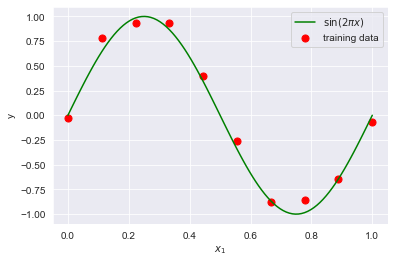

In [20]:
num_samples = 10
X, y = create_nonlin_training_set(nonlin, num_samples, 0.2) #try 0.001, 0.01, 0.1, 1, 10 and check the effect on data
visualize_training_data(X, y)


Lets train multiple polynomial regression models with different degrees

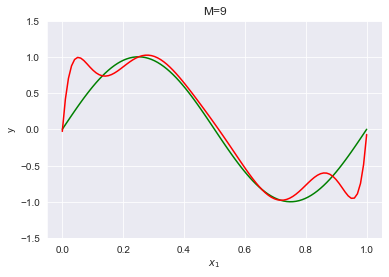

In [21]:
degree = 9
X_transform = polynomial_transform(X, degree)
lin_reg = LinReg()
lin_reg.fit(X_transform, y)
visualize_model_fit(X,y,lin_reg,degree)

In [22]:
X_transform[:5]

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.11111111e-01, 1.23456790e-02, 1.37174211e-03,
        1.52415790e-04, 1.69350878e-05, 1.88167642e-06, 2.09075158e-07,
        2.32305731e-08, 2.58117479e-09],
       [1.00000000e+00, 2.22222222e-01, 4.93827160e-02, 1.09739369e-02,
        2.43865264e-03, 5.41922810e-04, 1.20427291e-04, 2.67616202e-05,
        5.94702672e-06, 1.32156149e-06],
       [1.00000000e+00, 3.33333333e-01, 1.11111111e-01, 3.70370370e-02,
        1.23456790e-02, 4.11522634e-03, 1.37174211e-03, 4.57247371e-04,
        1.52415790e-04, 5.08052634e-05],
       [1.00000000e+00, 4.44444444e-01, 1.97530864e-01, 8.77914952e-02,
        3.90184423e-02, 1.73415299e-02, 7.70734663e-03, 3.42548739e-03,
        1.52243884e-03, 6.76639485e-04]])

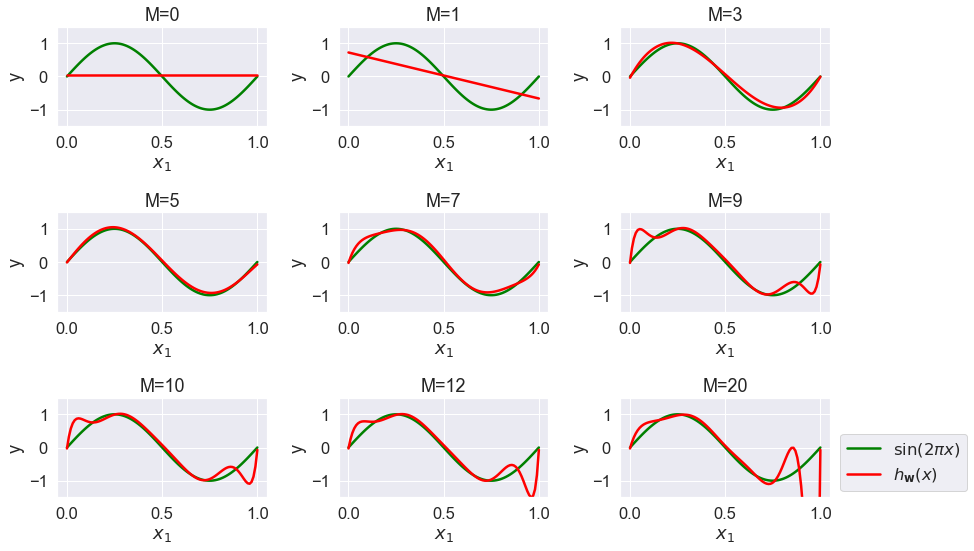

In [23]:
f = plt.figure(figsize=(12,8))
sns.set_context("notebook", font_scale = 1.5, rc = {"lines.linewidth":2.5 })

for i, degree in enumerate([0, 1, 3, 5, 7, 9, 10, 12, 20]):
  plt.subplot(3, 3, i + 1)
  X_transform = polynomial_transform(X, degree)
  lin_reg = LinReg()
  lin_reg.fit(X_transform, y)
  visualize_model_fit(X, y, lin_reg, degree)

f.tight_layout()
plt.legend(bbox_to_anchor=(1.05,0.64), loc = 2, borderaxespad = 0.)
plt.show()

#Model selection

* One polynomial model per degree. Which one to select ?
* Process
  * Fix the list of degrees that you want to experiment with
  * Divide the training data into training, validation and test.
  * For each degree m:
    * Training polynomial regression model with training data
    * Calculate training and validation errors on the trained model.
* Select the model with lowest training and validation loss among all models


In [24]:
#Model selection helpers
import pandas as pd

def convert_dict_to_df(w_dict, degree):
  poly_w_dict = {i:np.array(np.zeros(degree)) for i in range(degree)}
  for deg in poly_w_dict:
    weight_vec = w_dict[deg]
    for i in range(len(weight_vec)):
      poly_w_dict[deg][i] = weight_vec[i]
  
  poly_w_df = pd.DataFrame(poly_w_dict)
  poly_w_df.columns = ['w_' +str(i) for i in range(degree)]
  return poly_w_df

def plot_model_selection(traininig_errors, val_errors):
  plt.plot(traininig_errors, 'o-', mfc= 'none', mec = "b", ms =10, c='g',label = "$Training Erros$")
  plt.plot(val_errors, 'o-', mfc= 'none', mec = "r", ms =10, c='r',label = "$Validation Erros$")
  plt.legend()
  plt.xlabel("degree")
  plt.ylabel("RMSE")
  plt.show()


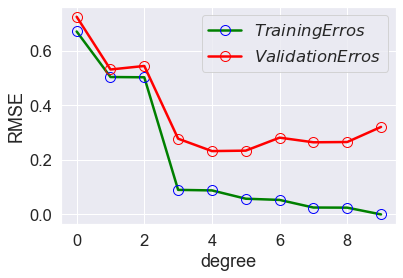

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9
0,0.029613,0.722758,0.670500,-0.038147,-0.058189,-0.013028,-0.021195,-0.028984,-0.028704,-0.029059
1,0.000000,-1.386290,-1.033546,10.633810,11.385420,7.271229,9.450562,17.874132,15.867461,52.961041
2,0.000000,0.000000,-0.352744,-31.102935,-34.898565,-0.604230,-27.491247,-166.486748,-126.019355,-982.816426
3,0.000000,0.000000,0.000000,20.500127,26.588167,-70.350486,45.373757,869.632955,564.404425,8281.890723
4,0.000000,0.000000,0.000000,0.000000,-3.044020,108.069625,-115.564685,-2446.207864,-1294.750096,-37550.471870
5,0.000000,0.000000,0.000000,0.000000,0.000000,-44.445458,154.481168,3553.238205,1156.013800,99930.066672
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-66.308875,-2532.808641,263.953164,-161472.576852
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,704.714219,-1007.588928,155866.799442
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,428.075787,-82569.887630
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18443.991870


In [25]:
training_errors = []
val_errors = []
w_dict = {}

X_val = np.linspace(0, 1 , 100)
y_val = nonlin(X_val)

for i in range(10):
  X_transform = polynomial_transform(X, i)
  X_val_transform = polynomial_transform(X_val, i)
  lin_reg = LinReg()
  lin_reg.fit (X_transform, y)

  w_dict[i]= lin_reg.w
  training_errors.append(lin_reg.rmse(X_transform, y))
  val_errors.append(lin_reg.rmse(X_val_transform, y_val + np.random.normal(scale=0.25, size = len(y_val))))

plot_model_selection(training_errors, val_errors)
convert_dict_to_df(w_dict, 10)


In [26]:
w_dict
df = pd.DataFrame.from_dict(w_dict,orient='index')
df.transpose()

,0,1,2,3,4,5,6,7,8,9
0,0.029613,0.722758,0.670500,-0.038147,-0.058189,-0.013028,-0.021195,-0.028984,-0.028704,-0.029059
1,NaN,-1.386290,-1.033546,10.633810,11.385420,7.271229,9.450562,17.874132,15.867461,52.961041
2,NaN,NaN,-0.352744,-31.102935,-34.898565,-0.604230,-27.491247,-166.486748,-126.019355,-982.816426
3,NaN,NaN,NaN,20.500127,26.588167,-70.350486,45.373757,869.632955,564.404425,8281.890723
4,NaN,NaN,NaN,NaN,-3.044020,108.069625,-115.564685,-2446.207864,-1294.750096,-37550.471870
5,NaN,NaN,NaN,NaN,NaN,-44.445458,154.481168,3553.238205,1156.013800,99930.066672
6,NaN,NaN,NaN,NaN,NaN,NaN,-66.308875,-2532.808641,263.953164,-161472.576852
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,704.714219,-1007.588928,155866.799442
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,428.075787,-82569.887630
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18443.991870


#Obervations:

 * Higher order polynomial terms are assigned larger weights. The larger weights are problematic as a small change in the input causes a large change in the output

 * This is called ' high variance' problem or overfitting problem.

   * We can fix the overfitting problem with more data. try running the analysis with number of samples = 100, 1000, 10000 and observe the weights for higher order polynomial models.

   * Note down which polynomial model is suitable for different samples size.
   

# We can set the number of samples required and control the noise added to examples through std parameter

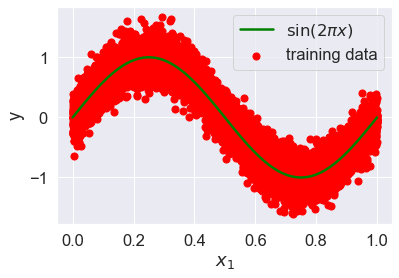

In [27]:
num_samples = 10000
X, y = create_nonlin_training_set(nonlin, num_samples, 0.2)
visualize_training_data(X, y)

#Ridge and Lasso Regression

We implement ridge regression from scratch and demonstrate lasso from sklearn library in this colab

There are two ways to tackle the problem of overfitting:
 * Train with more data
 * Penalize the weight vector through regularization

We will focus on point #2.
 * Regularization leads to change in Linear Regression loss functionm which inturn results in change of gradient calculation.
 * We plan to demonstrate the use of regularization with polynomial regression model and synthetically generated non-linear data set.

Finally we demonstrate ridge and lasso solution path as a function of regularization $λ$.

1. Loss Function (loss) : $\ J (w) = \frac{1}{2} (Xw - y)^{T} (Xw - y) + \color{blue} {\frac {λ}{2} w^{T}w} $

2. Gradient calculation (calculate_gradient): $\ \frac {∂J(w)}{∂w} = X^{T}(Xw-y) + \color{blue} {λw} $

3. Normal equation (fit) : $\ \mathbf{w} = (\mathbf{X}^{T}\mathbf{X} + \color{blue}{λI})^{-1} \mathbf{X}^{T} \mathbf{y} $

# Reuse Linear regression class with additional $λ$ added as noise

In [28]:
class LinReg(object):
  def __init__(self):
    self.t0 = 20
    self.t1 = 100

  def predict(self,X:np.ndarray):
    y = X @ self.w
    return y
  
  def loss(self, X:np.ndarray, y:np.ndarray, reg_rate:float):
    e = y - self.predict(X)
    # return ((1/2)*(np.transpose(e) @ e))
    return ((1/2) * (np.transpose(e) @ e) + (reg_rate/2) * (np.transpose(self.w)  @ self.w))

  def rmse (self, X:np.ndarray, y:np.ndarray):
    return np.sqrt((2/X.shape[0]) * self.loss(X,y,0))
  
  def fit (self, X:np.ndarray, y:np.ndarray, reg_rate:float):
    self.w = np.zeros((X.shape[1]))
    eye = np.eye(np.size(X, 1))
    #self.w = np.linalg.pinv(X) @ y
    self.w = np.linalg.solve(reg_rate * eye + (np.transpose(X) @ X), np.transpose(X) @ y,)
    return self.w
  
  def calculate_gradient(self, X:np.ndarray, y:np.ndarray, reg_rate:float):
    #return(np.transpose(X) @ (self.predict(X)-y))
    return(np.transpose(X) @ (self.predict(X)-y)) + reg_rate *self.w
  
  def update_weights(self, grad:np.ndarray, lr:float):
    return(self.w - lr*grad)

  def learning_schedule(self,t):
    return self.t0 / (t*self.t1)

  def gd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, lr:float,reg_rate:float):
    self.w = np.zeros((X.shape[1]))
    self.w_all = []
    self.err_all = []
    for i in np.arange(0,num_epochs):
      self.w_all.append(self.w)
      self.err_all.append(self.loss(X,y,reg_rate))
      djdw = self.calculate_gradient(X,y,reg_rate)
      self.w = self.update_weights(djdw,lr)
    return self.w

  def mbgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, batch_size:int, reg_rate:float):
    self.w = np.zeros((X.shape[1]))
    self.w_all = []
    self.err_all = []
    mini_batch_id = 0

    for epoch in range(num_epochs):
      shuffled_indices = np.random.permutation(X.shape[0])
      X_shuffled = X[shuffled_indices]
      y_shuffled = y[shuffled_indices]
      for i in range(0,X.shape[0],batch_size):
        mini_batch_id += 1
        xi = X_shuffled[i:i+batch_size]
        yi = y_shuffled[i:i+batch_size]
        self.w_all.append(self.w)
        self.err_all.append(self.loss(xi,yi))
        djdw = 2/batch_size * self.calculate_gradient(xi,yi,reg_rate)
        self.w = self.update_weights(djdw,self.learning_schedule(mini_batch_id))
    return self.w

  def sgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, reg_rate:float):
    self.w = np.zeros((X.shape[1]))
    self.w_all = []
    self.err_all = []
    mini_batch_id = 0

    for epoch in range(num_epochs):
      for i in range(X.shape[0]):
        random_index = np.random.randint(X.shape[0])
        xi = X[random_index]
        yi = y[random_index]
        self.w_all.append(self.w)
        self.err_all.append(self.loss(xi,yi))
        djdw = 2 * self.calculate_gradient(xi,yi,reg_rate)
        self.w = self.update_weights(djdw,self.learning_schedule(epoch * X.hape[0] + i))
    return self.w

In [29]:
feature_matrix = np.array([[1,3,2,5],[1,9,4,7]])
weight_vector = np.array([1,1,1,1])
label_vector = np.array([6,11])
reg_rate = 0.01
expected_loss = np.array([62.52])

lin_reg = LinReg()
lin_reg.w = weight_vector
loss_value = lin_reg.loss(feature_matrix, label_vector, reg_rate)
print(loss_value)

62.52


#Gradient Calculation Test

In [30]:
feature_matrix = np.array([[1,3,2,5],[1,9,4,7]])
weight_vector = np.array([1,1,1,1])
label_vector = np.array([6,11])
reg_rate = 0.01
expected_loss = np.array([15.01, 105.01, 50.01, 95.01])

lin_reg = LinReg()
lin_reg.w = weight_vector
loss_value = lin_reg.calculate_gradient(feature_matrix, label_vector, reg_rate)
print(loss_value)

[ 15.01 105.01  50.01  95.01]


# Ridge regression for fixing overfitting in polynomial regression

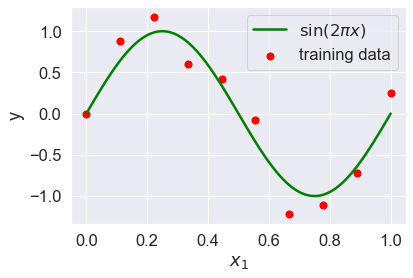

In [31]:
num_samples = 10
X, y = create_nonlin_training_set(nonlin, num_samples, 0.2)
visualize_training_data(X, y)

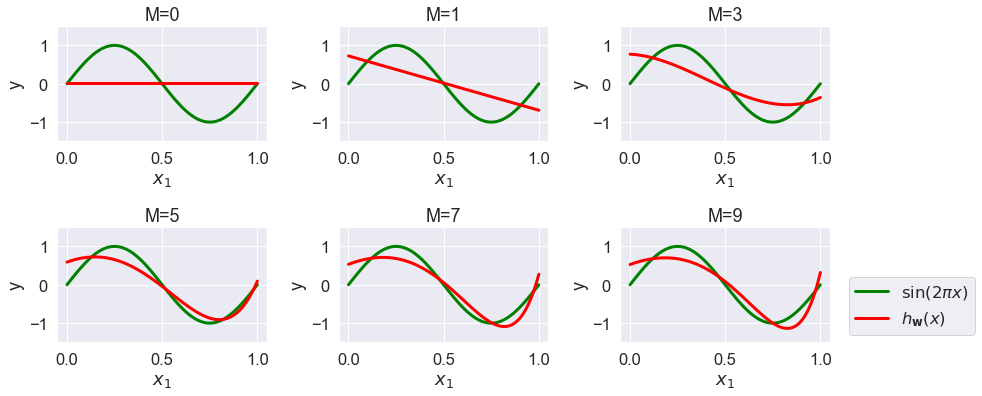

In [32]:
#@title [Polynomial regression with ridge regularization]
f = plt.figure(figsize = (12,8))
sns.set_context("notebook", font_scale=1.5, rc = {"lines.linewidth" : 3})

for i, degree in enumerate([0, 1, 3, 5, 7, 9]):
  plt.subplot(3, 3, i + 1)
  X_transform = polynomial_transform(X, degree)
  lin_reg = LinReg()
  lin_reg.fit(X_transform, y, reg_rate = 0.01)
  visualize_model_fit(X, y, lin_reg, degree)

f.tight_layout()
plt.legend(bbox_to_anchor= (1.05, 0.64), loc = 2, borderaxespad = 0.5)
plt.show()

Let's run a polynomial regression of degree = 9 with different regularization rate and fixed degree

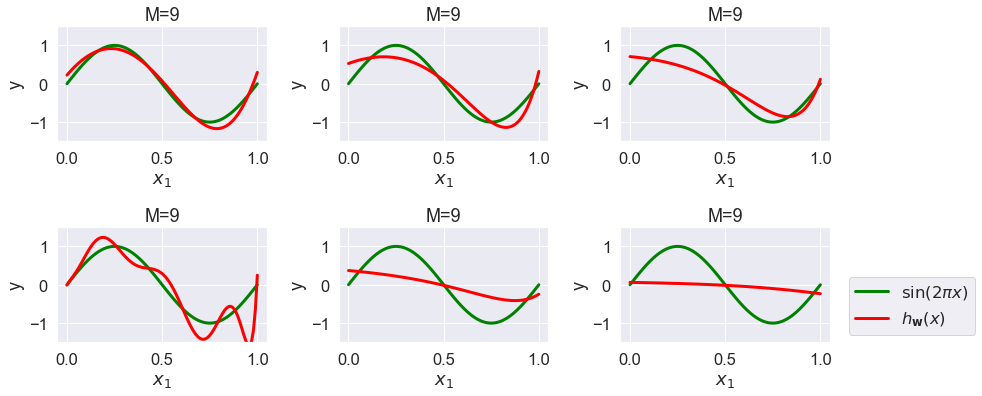

In [33]:
#@title [Polynomial regression with ridge regularization]
f = plt.figure(figsize = (12,8))
sns.set_context("notebook", font_scale=1.5, rc = {"lines.linewidth" : 3})
degree = 9

for i, reg_rate in enumerate([1e-3, 1e-2, 1e-1, 0, 1, 10]):
  plt.subplot(3, 3, i + 1)
  X_transform = polynomial_transform(X, degree)
  lin_reg = LinReg()
  lin_reg.fit(X_transform, y, reg_rate)
  visualize_model_fit(X, y, lin_reg, degree)

f.tight_layout()
plt.legend(bbox_to_anchor= (1.05, 0.64), loc = 2, borderaxespad = 0.5)
plt.show()

# Model Selection

  * One Model per $λ$. Which one to select ?
  * Process
    * Fix the list of λ that you want to experiment with.
    * Divide the training data into training, validation and test.
    * For each λ:
      * Training ridge regression model with λ for training data.
      * Calculate training and validation errors on the trained model.
  * Select the model with lowest training and validation loss among the models.

In [34]:
#title [Model selection helper function]
def plot_reg_w(w_df):
  ax = plt.gca()
  ax.plot(w_df.T)
  ax.set_xscale('log')
  ax.set_xlim(ax.get_xlim()[::-1])
  plt.xlabel('$\lamda$')
  plt.ylabel('$\mathbf{w}$')
  plt.title('Weights as a function of $\lambda$')
  plt.axis('tight')
  plt.show()

def plot_learning_curve(err_df):
  ax = plt.gca()
  ax.plot(err_df)
  ax.set_xscale('log')
  ax.set_xlim(ax.get_xlim()[::-1])
  plt.xlabel('$\lamda$')
  plt.ylabel('RMSE')
  plt.title('Training and validation losses as a function of')
  plt.axis('tight')
  plt.legend(['training', 'validation'])
  plt.show()

In [35]:
#Model selection fixing degree and changing lamda
import pandas as pd
training_errors = {}
val_errors = {}
w_dict = {}
degree = 9

X_val = np.linspace(0, 1 , 100)
y_val = nonlin(X_val)

X_transform = polynomial_transform(X, degree)
X_val_transform = polynomial_transform(X_val, degree)

for reg_rate in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]:
  lin_reg = LinReg()
  lin_reg.fit (X_transform, y, reg_rate)

  w_dict[reg_rate]= lin_reg.w
  training_errors[reg_rate] = lin_reg.rmse(X_transform, y)
  val_errors[reg_rate] = lin_reg.rmse(X_val_transform, y_val + np.random.normal(scale=0.25, size = len(y_val)))

err_df = pd.DataFrame([training_errors, val_errors]).T
w_df = pd.DataFrame(w_dict)

In [36]:
print(err_df)

                   0         1
0.000001    0.143077  0.269516
0.000010    0.153777  0.283222
0.000100    0.158552  0.262377
0.001000    0.191925  0.305437
0.010000    0.313661  0.327254
0.100000    0.418277  0.457316
1.000000    0.597367  0.587881
10.000000   0.733481  0.720109
100.000000  0.768277  0.724436


In [37]:
print(w_df)

   0.000001    0.000010    0.000100    0.001000    0.010000    0.100000    \
0    0.006244    0.034379    0.071857    0.224878    0.527362    0.707482   
1   12.154714    9.591870    8.307038    5.843146    1.803463   -0.450254   
2  -46.019195  -24.713917  -17.383575  -11.479011   -4.143721   -1.477906   
3   64.426797   11.121364   -2.824352   -4.363289   -2.628149   -1.088293   
4  -29.580450   -1.349062    3.495316    1.782826   -0.638634   -0.509909   
5  -40.746795   -3.250162    5.750723    4.534200    0.675651   -0.006940   
6   10.848935    5.446188    5.778186    4.578745    1.302983    0.380945   
7   44.911915   10.876371    3.669552    2.806863    1.423033    0.667013   
8   25.399791    5.139568   -0.454586   -0.074890    1.208488    0.873691   
9  -41.154232  -12.643259   -6.151706   -3.555836    0.790502    1.021353   

   1.000000    10.000000   100.000000  
0    0.370787    0.061996    0.003261  
1   -0.446180   -0.086005   -0.012451  
2   -0.472571   -0.087523   -0.0

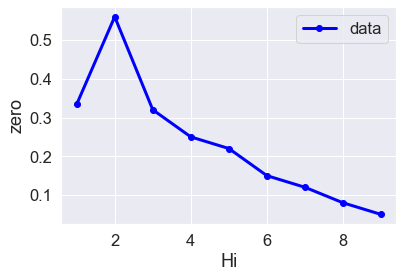

In [38]:
import matplotlib.pyplot as plt

plt.plot([1,2,3,4,5,6,7,8,9],[0.33393,0.56,0.32,0.25,0.22,0.15,0.12,0.08,0.05],"o-",c = 'b',label = "data")
plt.xlabel("Hi")
plt.ylabel("zero")
plt.legend()
plt.show()

#Lasso Regression

Lasso used $\ \mathbf{L}_{1}$ norm of weight vector instead of $\ \mathbf{L}_{2} $ as used in ridge regression.

Lasso does not have closed form solution and it's loss function is not differentiable at all points. We need to use specialised algorithm to learn lasso parameters. We will use sklearn Lasso implementtaion

In [39]:
from sklearn.linear_model import Lasso

#Lasso

reg_rate = 0.01
lasso = Lasso(alpha=reg_rate)
lasso.fit(X_transform, y)
# X_Transform is a Training set generated from non-linar mapping

#Linear regerssion (Ridge regression)
lin_reg = LinReg()
__ = lin_reg.fit(X_transform, y, 0)

In [40]:
pd.DataFrame({'LinReg': lin_reg.w, 'Ridge': w_df[0.01], 'Lasso':lasso.coef_})

,LinReg,Ridge,Lasso
0,-0.009630,0.527362,0.000000
1,8.639167,1.803463,-0.000000
2,-97.664572,-4.143721,-3.050066
3,2091.442489,-2.628149,-0.000000
4,-17418.540535,-0.638634,-0.000000
5,68400.594805,0.675651,0.000000
6,-144430.447080,1.302983,0.000000
7,168829.462990,1.423033,0.000000
8,-102916.927028,1.208488,0.000000
9,25533.699419,0.790502,2.469365


In [41]:
import pandas as pd
D = {1:"0,1", 2:"2,3",4:"5,6"}
print(pd.DataFrame(D.items(),columns =("Weight","Linear")))


   Weight Linear
0       1    0,1
1       2    2,3
2       4    5,6


#Observations:
1. Lasso obtains a sparse feature vector. many 0 coefficients or weights.
2. Ridge regression assigns small weights to each feature

A couple of points about using Lasso and Ridge:
* Lasso is used for feature selection
* While modelling relationships between features and labels,
    * When all features are useful for making prediction about the output, we use ridge regression. It produces a weight vector with small non-zero values to all features
    * When a few features are useful for making a predictions, we use lasso. It produces weight vector that assigns 0 weights to unimportant features


# Lets look at Lasso with different regularization rates:

Text(0.5, 1.0, 'lasso Regression (M=9, $\\lambda=0.01$)')

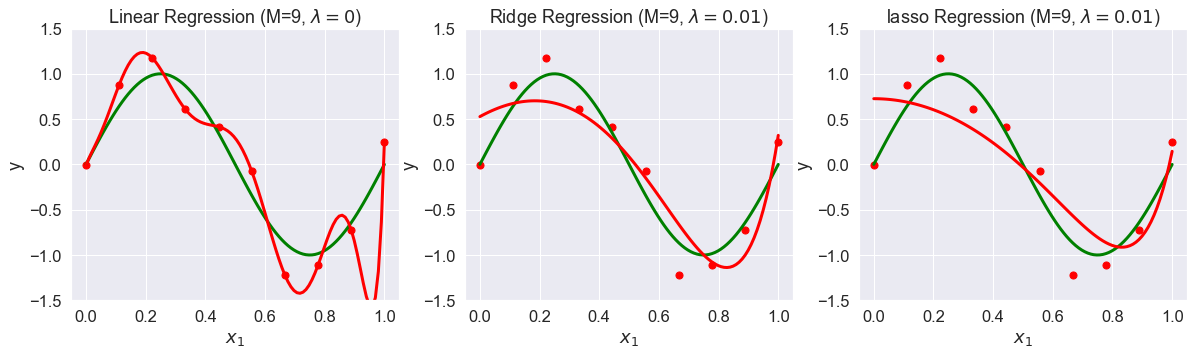

In [42]:
def visualize_model_fit(X, y, lin_reg, degree,reg_rate):
  points = np.linspace(0,1,100)
  output = nonlin(points)

  if degree > 0:
     plt.scatter(X ,y, facecolor="none", edgecolor = 'face', c = 'r', s=50, label="training data")
  plt.plot(points, output, c='g', label = "$\sin(2\pi x)$")
  y_hat = lin_reg.predict(polynomial_transform(points, degree, logging = False))
  plt.plot(points, y_hat, c='r', label = "$h_\mathbf{w} (x)$")
  plt.xlabel('$x_1$')
  plt.ylabel('y')
  plt.ylim(-1.5,1.5)
  plt.title("M={}".format(degree)) #xy = (-0.15, 1)


f = plt.figure(figsize=(20,5))
ax1 = plt.subplot(1,3,1)
visualize_model_fit(X,y,lin_reg,degree,reg_rate = 0)
plt.title('Linear Regression (M=9, $\lambda=0$)')

lin_reg.w = w_df[0.01]
ax2 = plt.subplot(1,3,2)
visualize_model_fit(X,y,lin_reg,degree,reg_rate=0.01)
plt.title('Ridge Regression (M=9, $\lambda=0.01$)')

ax3 = plt.subplot(1,3,3)
visualize_model_fit(X,y,lasso,degree,reg_rate=0.01)
plt.title('lasso Regression (M=9, $\lambda=0.01$)')

# As in case of Ridge regression, we need to select best λ at Training and Validation sets

#Model Selection

In [43]:


import pandas as pd
from sklearn.metrics import mean_squared_error
training_errors = {}
val_errors = {}
w_dict = {}
degree = 9

X_val = np.linspace(0, 1 , 100)
y_val = nonlin(X_val)

X_transform = polynomial_transform(X, degree)
X_val_transform = polynomial_transform(X_val, degree)

for reg_rate in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]:
  lasso = Lasso(alpha = reg_rate)
  lasso.fit (X_transform, y)

  w_dict[reg_rate]= lasso.coef_
  training_errors[reg_rate] = mean_squared_error(y, lasso.predict(X_transform), squared = False)
  val_errors[reg_rate] = mean_squared_error(y_val + np.random.normal(scale=0.25, size = len(y_val)),lasso.predict(X_val_transform),squared = False)

err_df = pd.DataFrame([training_errors, val_errors]).T
w_df = pd.DataFrame(w_dict)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1265853844693169, tolerance: 0.0006008949137682125
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1205871530849123, tolerance: 0.0006008949137682125
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07221070762984601, tolerance: 0.0006008949137682125
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: C

                   0         1
0.000001    0.159560  0.277514
0.000010    0.159725  0.288733
0.000100    0.162027  0.274587
0.001000    0.215198  0.254153
0.010000    0.400135  0.391414
0.100000    0.699847  0.677262
1.000000    0.775174  0.732327
10.000000   0.775174  0.744237
100.000000  0.775174  0.740647
            Training  Validation
0.000001    0.159560    0.277514
0.000010    0.159725    0.288733
0.000100    0.162027    0.274587
0.001000    0.215198    0.254153
0.010000    0.400135    0.391414
0.100000    0.699847    0.677262
1.000000    0.775174    0.732327
10.000000   0.775174    0.744237
100.000000  0.775174    0.740647


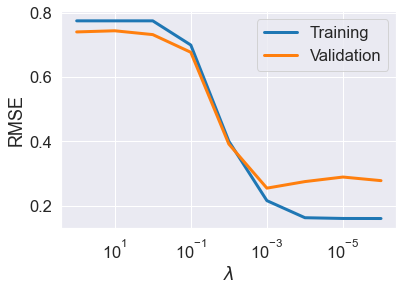

In [44]:
print(err_df)
err_df.rename(columns={0:'Training',1:'Validation'},inplace = True)
print(err_df)
err_df.plot()
plt.xscale("log")
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.gca().invert_xaxis()
plt.show()

# Ridge and Lasso Visulization

# Ridge solution as a function of λ

Remember that the ridge regression calculates loss os follows:
$$\ \mathbf{J(w)} = \frac {1} {2} (Xw - y)^T (Xw - y) + \frac {λ}{2} w^Tw $$

Now,
* The first part of the equation $\ (Xw-y)^T (Xw-y) $ gives rise to slliptical contours centered around the linear regression or least square error solution.
* The second part of the equation $\ w^Tw $ represents a circle.
* The ridge regression solution lies at the intersection between contours of these two functions - slliptical and circular contours. The intersection varies as a function of λ.
  * As λ &rarr; 0, the solution is of least square error.
  * As λ &rarr; ∞, the solution is at the center of circle, which is 0 vector.


#Ridge Solution visulization

Steps:
 1. Generate synthetic data.
 2. Obtain weight vector for ridge regression model with 100 different values of λ = {0.001,....,10} in ascending order.
 3. Set up mesh grid of weight values. Lets call it as $\mathbf{W}$
 4. For each $\mathbf{w}$ in $\mathbf{W} $:
    * Compute mean squared error for w
    * Compute ridge regularization or constraint $\mathbf{w}^{T} \mathbf{w}$
 5. Draw contours for mean squared error and ridge regression constraints.
 6. Draw path of weight vectors from least men squared error value to the lease value of ridge constraints.

# Lasso solution as a function of λ

Remember that the ridge regression calculates loss os follows:
$$\ \mathbf{J(w)} = \frac {1} {2} (Xw - y)^T (Xw - y) + \frac {λ}{2} \||w||_{1} $$

Now,
* The first part of the equation $\ (Xw-y)^T (Xw-y) $ gives rise to slliptical contours centered around the linear regression or least square error solution.
* The second part of the equation $\||w||_{1} $ represents a polytope.
* The ridge regression solution lies at the intersection between contours of these two functions - slliptical and circular contours. The intersection varies as a function of λ.
  * As λ &rarr; 0, the solution is of least square error.
  * As λ &rarr; ∞, the solution is at the center of circle, which is 0 vector.

#Lasso Solution visulization

Steps:
 1. Generate synthetic data.
 2. Obtain weight vector for lasso regression model with 100 different values of λ = {0.001,....,10} in ascending order.
 3. Set up mesh grid of weight values. Lets call it as $\mathbf{W}$
 4. For each $\mathbf{w}$ in $\mathbf{W} $:
    * Compute mean squared error for w
    * Compute ridge regularization or constraint $\ ||w||_1$
 5. Draw contours for mean squared error and lasso regression constraints.
 6. Draw path of weight vectors from least men squared error value to the least value of lasso constraints (apperas to [0,0]).

# Multi-output / Multi-label regression Problem

Training Data

$\mathbf{D}$ = $\ (\mathbf{X,Y}) $ = $\ {( x^{(i)}, y^{(i)})}^{n}_{i=0} $

Here $\ y^{i} 𝝐 R ^{k} $ where k is the number of output labels. In simple terms, $\ y^{i}$ has components that are real numbers.

Let's generate synthetic data for demonstrating the training set with multi regression

In [45]:
from sklearn.datasets import make_regression
X, y, coef = make_regression(n_samples = 100, n_features = 10, n_informative = 10, bias = 1, n_targets = 5, shuffle = True, coef = True, random_state = 42)

In [46]:
print(X.shape)
print(y.shape)
print(X[:5])
print(y[:5])

(100, 10)
(100, 5)
[[-2.07339023 -0.37144087  1.27155509  1.75227044  0.93567839 -1.40751169
  -0.77781669 -0.34268759 -1.11057585  1.24608519]
 [-0.90938745 -1.40185106 -0.50347565 -0.56629773  0.09965137  0.58685709
   2.19045563  1.40279431 -0.99053633  0.79103195]
 [-0.18565898 -1.19620662 -0.64511975  1.0035329   0.36163603  0.81252582
   1.35624003 -1.10633497 -0.07201012 -0.47917424]
 [ 0.03526355  0.21397991 -0.57581824  0.75750771 -0.53050115 -0.11232805
  -0.2209696  -0.69972551  0.6141667   1.96472513]
 [-0.51604473 -0.46227529 -0.8946073  -0.47874862  1.25575613 -0.43449623
  -0.30917212  0.09612078  0.22213377  0.93828381]]
[[-133.15919852  -88.95797818   98.19127175   25.68295511 -132.79294654]
 [-110.38909784  146.04459736 -169.58916067  118.96066861 -177.08414159]
 [ -97.80350267    4.32654061  -87.56082281   -5.58466452    6.36897388]
 [  25.39024616  -70.41180117  186.15213706  132.77153362   53.42301307]
 [-140.61925153  -53.87007831 -101.11514549 -113.36926374 -115.

In [47]:
X = add_dummy_feature(X)
print(X[:5])


[[ 1.         -2.07339023 -0.37144087  1.27155509  1.75227044  0.93567839
  -1.40751169 -0.77781669 -0.34268759 -1.11057585  1.24608519]
 [ 1.         -0.90938745 -1.40185106 -0.50347565 -0.56629773  0.09965137
   0.58685709  2.19045563  1.40279431 -0.99053633  0.79103195]
 [ 1.         -0.18565898 -1.19620662 -0.64511975  1.0035329   0.36163603
   0.81252582  1.35624003 -1.10633497 -0.07201012 -0.47917424]
 [ 1.          0.03526355  0.21397991 -0.57581824  0.75750771 -0.53050115
  -0.11232805 -0.2209696  -0.69972551  0.6141667   1.96472513]
 [ 1.         -0.51604473 -0.46227529 -0.8946073  -0.47874862  1.25575613
  -0.43449623 -0.30917212  0.09612078  0.22213377  0.93828381]]


In [48]:
X_train, X_test, y_train, y_test = preprocess(X,y)

In [49]:
coef

array([[93.62122462,  5.19712837, 54.12963353, 70.90605195, 87.09691237],
       [89.48166561, 54.75923762, 81.729777  , 45.23182845, 64.35776952],
       [46.26229567, 86.82725054, 72.71690698, 74.27065212, 42.54933344],
       [71.92017783, 22.84547413, 99.63339161, 97.47931621, 65.03256863],
       [19.95424509, 68.02282424,  7.2198409 ,  3.06525022, 25.76828885],
       [52.64026609, 73.15895218,  8.1629982 ,  6.0352084 , 24.7103234 ],
       [15.95446801, 87.17835666, 21.92139874, 97.58652558, 33.68957918],
       [71.40869321, 80.17280831, 33.94501925, 81.48251137,  8.01148464],
       [18.21179157, 78.96985071, 65.87077755, 49.81957165, 55.53635509],
       [16.74825823, 10.45678403, 63.64302495, 70.64757265,  3.15861448]])

# Model

The Linear regression model is exactly same as single label output except that the output is now a vector.

$$\ \mathbf{Y}_{n \times k} = \mathbf{X}_{n \times (m+1)} \mathbf{W}_{(m+1) \times k}$$

In this equation, the output label is Matrix $\mathbf{Y}$. In Order to generate multiple outputs, we need one weight vector per output. hence, total of k weight vectors corresponding to the k outputs.

There are two options for modelling this problem:

1.  Solve k independent linear regression problems. Gives some flexibility in using different representation for each problem.
2. Solve a joint learning problem as outlined in the equation above. We would pursue this approach.


# Loss

We use the same loss function as the linear regression i.e sum of squared error

$$\ \mathbf{J(W)} = \frac{1}{2} (XW - Y)^{T} (XW-Y) $$

#Optimization
 1. Normal quation
 2. Gradient descent and its variation

#Evaluation
 RMSE or LOSS


Use Linear regression model and do chnages to weight vector

 Changes to coding as below

 self.w = np.zeros((X.shape[1], y.shape[1]))  (create weight matrix)

 # checking
  np.testing.assert_almost_equal(w[1:,:], coef, decimal = 2)

In [50]:
class LinReg(object):
  def __init__(self):
    self.t0 = 20
    self.t1 = 100

  def predict(self,X:np.ndarray):
    y = X @ self.w
    return y
  
  def loss(self, X:np.ndarray, y:np.ndarray, reg_rate:float):
    e = y - self.predict(X)
    # return ((1/2)*(np.transpose(e) @ e))
    return ((1/2) * (np.transpose(e) @ e) + (reg_rate/2) * (np.transpose(self.w)  @ self.w))

  def rmse (self, X:np.ndarray, y:np.ndarray):
    return np.sqrt((2/X.shape[0]) * self.loss(X,y,0))
  
  def fit (self, X:np.ndarray, y:np.ndarray, reg_rate:float):
    self.w = np.zeros((X.shape[1],y.shape[1])) #chnage weight vector to shape m+1 x k
    eye = np.eye(np.size(X, 1))
    #self.w = np.linalg.pinv(X) @ y
    self.w = np.linalg.solve(reg_rate * eye + (np.transpose(X) @ X), np.transpose(X) @ y,)
    return self.w
  
  def calculate_gradient(self, X:np.ndarray, y:np.ndarray, reg_rate:float):
    #return(np.transpose(X) @ (self.predict(X)-y))
    return(np.transpose(X) @ (self.predict(X)-y)) + reg_rate *self.w
  
  def update_weights(self, grad:np.ndarray, lr:float):
    return(self.w - lr*grad)

  def learning_schedule(self,t):
    return self.t0 / (t*self.t1)

  def gd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, lr:float,reg_rate:float):
    self.w = np.zeros((X.shape[1],y.shape[1]))
    self.w_all = []
    self.err_all = []
    for i in np.arange(0,num_epochs):
      self.w_all.append(self.w)
      self.err_all.append(self.loss(X,y,reg_rate))
      djdw = self.calculate_gradient(X,y,reg_rate)
      self.w = self.update_weights(djdw,lr)
    return self.w

  def mbgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, batch_size:int, reg_rate:float):
    self.w = np.zeros((X.shape[1],y.shape[1]))
    self.w_all = []
    self.err_all = []
    mini_batch_id = 0

    for epoch in range(num_epochs):
      shuffled_indices = np.random.permutation(X.shape[0])
      X_shuffled = X[shuffled_indices]
      y_shuffled = y[shuffled_indices]
      for i in range(0,X.shape[0],batch_size):
        mini_batch_id += 1
        xi = X_shuffled[i:i+batch_size]
        yi = y_shuffled[i:i+batch_size]
        self.w_all.append(self.w)
        self.err_all.append(self.loss(xi,yi))
        djdw = 2/batch_size * self.calculate_gradient(xi,yi,reg_rate)
        self.w = self.update_weights(djdw,self.learning_schedule(mini_batch_id))
    return self.w

  def sgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, reg_rate:float):
    self.w = np.zeros((X.shape[1],y.shape[1]))
    self.w_all = []
    self.err_all = []
    mini_batch_id = 0

    for epoch in range(num_epochs):
      for i in range(X.shape[0]):
        random_index = np.random.randint(X.shape[0])
        xi = X[random_index]
        yi = y[random_index]
        self.w_all.append(self.w)
        self.err_all.append(self.loss(xi,yi))
        djdw = 2 * self.calculate_gradient(xi,yi,reg_rate)
        self.w = self.update_weights(djdw,self.learning_schedule(epoch * X.hape[0] + i))
    return self.w

In [51]:
lin_reg = LinReg()
w = lin_reg.fit(X_train,y_train,reg_rate = 0)
w[1:]



array([[93.62122462,  5.19712837, 54.12963353, 70.90605195, 87.09691237],
       [89.48166561, 54.75923762, 81.729777  , 45.23182845, 64.35776952],
       [46.26229567, 86.82725054, 72.71690698, 74.27065212, 42.54933344],
       [71.92017783, 22.84547413, 99.63339161, 97.47931621, 65.03256863],
       [19.95424509, 68.02282424,  7.2198409 ,  3.06525022, 25.76828885],
       [52.64026609, 73.15895218,  8.1629982 ,  6.0352084 , 24.7103234 ],
       [15.95446801, 87.17835666, 21.92139874, 97.58652558, 33.68957918],
       [71.40869321, 80.17280831, 33.94501925, 81.48251137,  8.01148464],
       [18.21179157, 78.96985071, 65.87077755, 49.81957165, 55.53635509],
       [16.74825823, 10.45678403, 63.64302495, 70.64757265,  3.15861448]])

In [52]:
coef # check both estimated weight vector and co-efficent matrix match

array([[93.62122462,  5.19712837, 54.12963353, 70.90605195, 87.09691237],
       [89.48166561, 54.75923762, 81.729777  , 45.23182845, 64.35776952],
       [46.26229567, 86.82725054, 72.71690698, 74.27065212, 42.54933344],
       [71.92017783, 22.84547413, 99.63339161, 97.47931621, 65.03256863],
       [19.95424509, 68.02282424,  7.2198409 ,  3.06525022, 25.76828885],
       [52.64026609, 73.15895218,  8.1629982 ,  6.0352084 , 24.7103234 ],
       [15.95446801, 87.17835666, 21.92139874, 97.58652558, 33.68957918],
       [71.40869321, 80.17280831, 33.94501925, 81.48251137,  8.01148464],
       [18.21179157, 78.96985071, 65.87077755, 49.81957165, 55.53635509],
       [16.74825823, 10.45678403, 63.64302495, 70.64757265,  3.15861448]])

In [53]:
X_train[:5]

array([[ 1.        , -0.54685894, -0.54342477,  1.09150685,  1.50399299,
        -2.65096981, -0.71284578,  0.10643023, -0.03275327, -0.25497722,
        -0.57366201],
       [ 1.        , -0.89725437, -0.67716171, -0.56372455, -0.32138584,
         0.41293145,  0.97511973, -0.14705738,  0.07580456, -0.8254972 ,
        -0.01224677],
       [ 1.        ,  0.59515703,  2.09238728,  0.62834551,  0.79166269,
         0.62411982, -1.00601738, -1.21418861, -0.81822068,  1.15811087,
         0.09699596],
       [ 1.        , -0.42064532, -0.80227727, -0.07444592,  0.17457781,
         0.25755039, -0.16128571,  0.40405086, -0.34271452,  1.8861859 ,
        -1.41537074],
       [ 1.        , -1.12905177,  0.48937456,  0.44426331, -0.37482081,
         0.71095997, -1.22212781,  0.71299843, -0.52452027, -0.2403254 ,
         0.72167206]])

In [54]:
y_train[:5]

array([[-4.54758564e+01, -1.54426836e+02,  7.91612822e+01,
         1.07378024e+02, -3.59268159e+01],
       [-1.45390645e+02, -6.96655772e+01, -2.20790273e+02,
        -2.09461095e+02, -1.81110075e+02],
       [ 2.34367657e+02,  8.11893679e+01,  3.53154837e+02,
         1.36912658e+02,  2.74103707e+02],
       [-1.11790257e+02,  1.00025648e+02, -4.34261532e+01,
        -4.83289782e+01,  3.47150766e+01],
       [-1.35833963e+02,  1.95667455e+01, -2.07706383e+00,
         1.91908844e-01, -7.44421535e+01]])

In [55]:
w = lin_reg.gd(X_train,y_train,num_epochs = 100, lr=0.01, reg_rate = 0)
w[1:]

array([[93.62122462,  5.19712837, 54.12963353, 70.90605195, 87.09691237],
       [89.48166561, 54.75923762, 81.729777  , 45.23182845, 64.35776952],
       [46.26229567, 86.82725054, 72.71690698, 74.27065212, 42.54933344],
       [71.92017783, 22.84547413, 99.63339161, 97.47931621, 65.03256863],
       [19.95424509, 68.02282424,  7.2198409 ,  3.06525022, 25.76828885],
       [52.64026609, 73.15895218,  8.1629982 ,  6.0352084 , 24.7103234 ],
       [15.95446801, 87.17835666, 21.92139874, 97.58652558, 33.68957918],
       [71.40869321, 80.17280831, 33.94501925, 81.48251137,  8.01148464],
       [18.21179157, 78.96985071, 65.87077755, 49.81957165, 55.53635509],
       [16.74825823, 10.45678403, 63.64302495, 70.64757265,  3.15861448]])

X = (80,11)
y = (80,5)

w = (11,5)

